<a href="https://colab.research.google.com/github/cetinpelin/pelinsprojects/blob/main/Deep_Learning_with_PyTorch_ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.6 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=9284dd78355d4ab41a660334eb902d9e7865e1110c7da8c4c379a284b69cc70e
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=01230f1a752bd9d0d058c749ecb1c210ce5d639752ce0043bf9341ebb4735d95
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c6

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 19.40 MiB/s, done.
Resolving deltas: 100% (3/3), done.


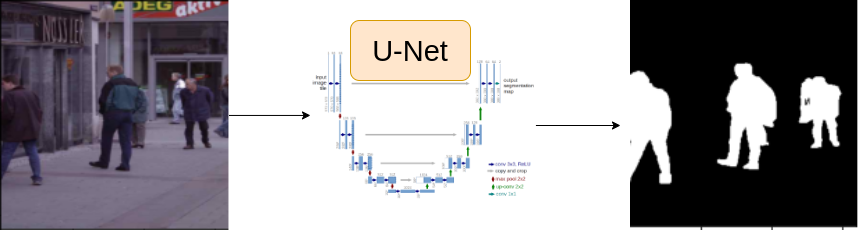

# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [5]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.0003
IMG_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'


In [6]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [7]:
row = df.iloc[0]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

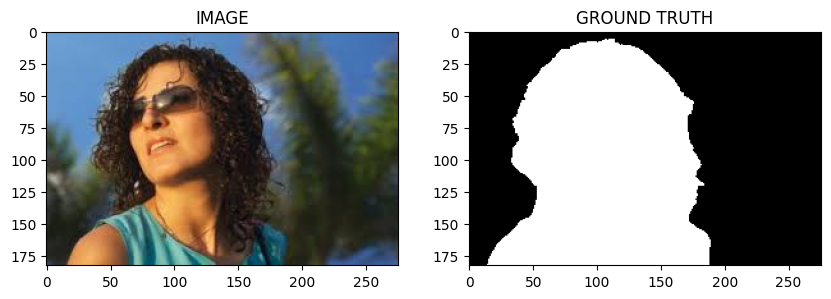

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [9]:
train_df, valid_df = train_test_split(df, test_size= 0.2, random_state= 42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [10]:
import albumentations as A

In [11]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p = 0.5),
      A.VerticalFlip(p = 0.5)],
      is_check_shapes =0
  )

def get_valid_augs():
  return A.Compose([
     A.Resize(IMG_SIZE, IMG_SIZE)],
     is_check_shapes =0)

# Task 4 : Create Custom Dataset

In [12]:
from torch.utils.data import Dataset

In [13]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):

    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):

    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) #(h, w, c)
    mask = np.expand_dims(mask, axis = -1)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

      #(h, w, c)-> (c, h, w)

      image = np.transpose(image, (2,0,1)).astype(np.float32)
      mask = np.transpose(mask, (2,0,1)).astype(np.float32)

      #transform Numpy to Tensor

      image = torch.Tensor(image) / 255.0
      mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask



In [14]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())




In [15]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


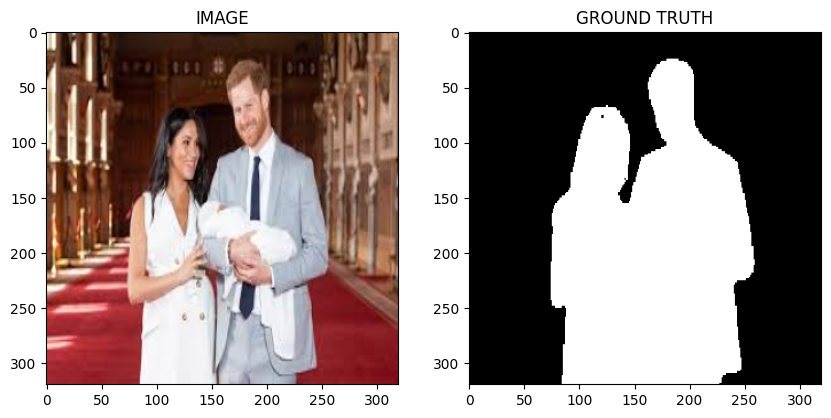

In [16]:
idx = 20

image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [17]:
from torch.utils.data import DataLoader

In [18]:
trainloader = DataLoader(trainset, batch_size =BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size =BATCH_SIZE)


In [19]:

print(f"total no. of batches in trainloader : {len(trainloader)}")
print(f"total no. of batches in validloader : {len(validloader)}")

total no. of batches in trainloader : 15
total no. of batches in validloader : 4


In [20]:
for image, mask in trainloader:
 break

print(f'One batch image shape: {image.shape}')
print(f'One batch mask shape: {mask.shape}')




One batch image shape: torch.Size([16, 3, 320, 320])
One batch mask shape: torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [21]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [22]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self, images, masks = None):

    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2

    return logits

In [23]:
model = SegmentationModel()
model.to(DEVICE);

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:01<00:00, 10.7MB/s]


# Task 7 : Create Train and Validation Function

In [24]:
def train_fn(data_loader, model, optimizer):

  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

    return total_loss / len(data_loader)



In [25]:
def eval_fn(data_loader, model):

  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):

      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)


      total_loss += loss.item()

  return total_loss / len(data_loader)

# Task 8 : Train Model

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [27]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
     torch.save(model.state_dict(), 'best_model.pt')
     print("SAVED MODEL")
     best_valid_loss = valid_loss

  print(f"Epoch : {i+1} Train_loss : {train_loss} Valid_loss: {valid_loss}")


100%|██████████| 4/4 [00:00<00:00,  4.70it/s]


SAVED MODEL
Epoch : 1 Train_loss : 0.09171613057454427 Valid_loss: 1.3536711037158966


100%|██████████| 4/4 [00:00<00:00,  5.15it/s]


SAVED MODEL
Epoch : 2 Train_loss : 0.08759075005849203 Valid_loss: 1.324421226978302


100%|██████████| 4/4 [00:01<00:00,  2.39it/s]


SAVED MODEL
Epoch : 3 Train_loss : 0.08090071678161621 Valid_loss: 1.304930567741394


100%|██████████| 4/4 [00:01<00:00,  3.02it/s]


SAVED MODEL
Epoch : 4 Train_loss : 0.08406201998392741 Valid_loss: 1.2853704988956451


100%|██████████| 4/4 [00:01<00:00,  3.36it/s]


SAVED MODEL
Epoch : 5 Train_loss : 0.07189373970031739 Valid_loss: 1.2477442026138306


100%|██████████| 4/4 [00:01<00:00,  3.21it/s]


SAVED MODEL
Epoch : 6 Train_loss : 0.06890182495117188 Valid_loss: 1.1864200234413147


100%|██████████| 4/4 [00:01<00:00,  3.48it/s]


SAVED MODEL
Epoch : 7 Train_loss : 0.06872881253560384 Valid_loss: 1.1379896402359009


100%|██████████| 4/4 [00:01<00:00,  3.47it/s]


SAVED MODEL
Epoch : 8 Train_loss : 0.07121241887410482 Valid_loss: 1.1202284097671509


100%|██████████| 4/4 [00:01<00:00,  2.87it/s]


SAVED MODEL
Epoch : 9 Train_loss : 0.06369260946909587 Valid_loss: 1.1145390272140503


100%|██████████| 4/4 [00:01<00:00,  2.12it/s]


Epoch : 10 Train_loss : 0.06504315137863159 Valid_loss: 1.122294843196869


100%|██████████| 4/4 [00:00<00:00,  5.31it/s]


Epoch : 11 Train_loss : 0.061274234453837076 Valid_loss: 1.121005579829216


100%|██████████| 4/4 [00:00<00:00,  5.13it/s]


SAVED MODEL
Epoch : 12 Train_loss : 0.061362020174662274 Valid_loss: 1.1135239452123642


100%|██████████| 4/4 [00:00<00:00,  5.14it/s]


SAVED MODEL
Epoch : 13 Train_loss : 0.05923835436503092 Valid_loss: 1.1132360845804214


100%|██████████| 4/4 [00:00<00:00,  5.22it/s]


SAVED MODEL
Epoch : 14 Train_loss : 0.06211328109105428 Valid_loss: 1.0857314467430115


100%|██████████| 4/4 [00:00<00:00,  5.17it/s]


SAVED MODEL
Epoch : 15 Train_loss : 0.05418190161387126 Valid_loss: 1.029653549194336


100%|██████████| 4/4 [00:00<00:00,  5.20it/s]


SAVED MODEL
Epoch : 16 Train_loss : 0.05834294557571411 Valid_loss: 0.9766141474246979


100%|██████████| 4/4 [00:00<00:00,  5.23it/s]


SAVED MODEL
Epoch : 17 Train_loss : 0.050517916679382324 Valid_loss: 0.9404504001140594


100%|██████████| 4/4 [00:00<00:00,  4.16it/s]


SAVED MODEL
Epoch : 18 Train_loss : 0.04458177884419759 Valid_loss: 0.8475404381752014


100%|██████████| 4/4 [00:01<00:00,  3.91it/s]


SAVED MODEL
Epoch : 19 Train_loss : 0.043369777997334796 Valid_loss: 0.76017627120018


100%|██████████| 4/4 [00:00<00:00,  5.24it/s]


SAVED MODEL
Epoch : 20 Train_loss : 0.05530849695205688 Valid_loss: 0.7252194732427597


100%|██████████| 4/4 [00:00<00:00,  5.24it/s]


SAVED MODEL
Epoch : 21 Train_loss : 0.04233545462290446 Valid_loss: 0.6305081993341446


100%|██████████| 4/4 [00:00<00:00,  5.21it/s]


SAVED MODEL
Epoch : 22 Train_loss : 0.04113294283548991 Valid_loss: 0.5453885868191719


100%|██████████| 4/4 [00:00<00:00,  5.24it/s]


SAVED MODEL
Epoch : 23 Train_loss : 0.04470330079396566 Valid_loss: 0.49128762632608414


100%|██████████| 4/4 [00:00<00:00,  5.14it/s]


SAVED MODEL
Epoch : 24 Train_loss : 0.04361952940622966 Valid_loss: 0.45414891093969345


100%|██████████| 4/4 [00:01<00:00,  3.77it/s]

SAVED MODEL
Epoch : 25 Train_loss : 0.03532098531723023 Valid_loss: 0.4201304018497467


# Task 9 : Inference

In [28]:
idx = 2

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) #(C, H, W) -> (1, C, H, W)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

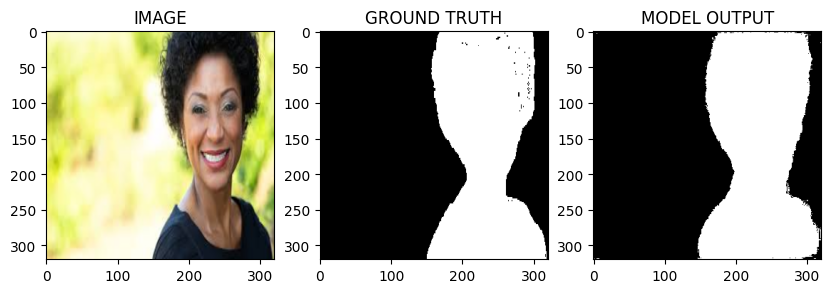

In [29]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya